In [1]:
import os, time
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

In [2]:
import seaborn as sns
sns.set(context='talk', style='ticks', font_scale=1.6)
%matplotlib inline

In [3]:
cat = Table.read('check-lslga-decam.fits')
#cat['RA_LSLGA', 'DEC_LSLGA', 'RA', 'DEC']
cat

LSLGA_ID,GALAXY,PGC,RA_LSLGA,DEC_LSLGA,MORPHTYPE,BAR,RING,MULTIPLE,COMPACTNESS,T,PA,D25,BA,DIAM_REF,Z,SB_D25,MAG,MAG_REF,WISE_RA,WISE_DEC,CNTR,W1MPRO,W1SIGMPRO,W2MPRO,W2SIGMPRO,W3MPRO,W3SIGMPRO,W4MPRO,W4SIGMPRO,RCHI2,CC_FLAGS,EXT_FLG,PH_QUAL,XSCPROX,W1RSEMI,W1BA,W1PA,W1GMAG,W1GERR,W2GMAG,W2GERR,W3GMAG,W3GERR,W4GMAG,W4GERR,IN_ALLWISE,IN_DESI,NEAR_BRIGHTSTAR,TYPE,RA,DEC,REF_CAT,REF_ID,FRACDEV,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2
int64,bytes29,int64,float64,float64,bytes4,bytes3,bytes3,bytes3,bytes3,float32,float32,float32,float32,bytes3,float32,float32,float32,bytes1,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float32,bytes4,int32,bytes4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bytes4,float64,float64,bytes2,int64,float32,float32,float32,float32,float32,float32,float32
18867,PGC1158616,1158616,18.817362000000003,0.16143929999999998,S?,nan,nan,M,nan,0.9,16.03,0.3499452,0.63095737,iso,0.060233667,23.888481,17.54,B,18.8173601,0.1614996,181100001351050240,14.362,0.029,14.08,0.044,10.466,0.096,8.619,0.508,1.447,0000,0,AAAC,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,True,True,False,EXP,18.81736164044832,0.16147225355676859,L2,18867,0.0,3.9760447,0.25567666,0.17052463,0.0,0.0,0.0
36217,PGC004504,4504,18.748374000000002,0.2591443,E,nan,nan,nan,nan,-4.1,92.28,0.4698941,0.73113906,iso,0.048351113,23.224482,16.236,B,18.7484038,0.2592324,181100001351050147,12.141,0.023,12.119,0.023,10.985,0.124,8.914,0.536,4.34,0000,5,AABC,0.29,11.56,0.95,-85.0,12.108,0.007,12.081,0.013,11.321,0.143,9.601,0.829,True,True,False,COMP,18.748393710179347,0.25920410232952495,L2,36217,0.703542,3.458333,-0.3737078,0.09831834,22.856623,-0.07103979,-0.054407787
83822,PGC073879,73879,18.876837000000002,0.2227993,E,nan,nan,nan,nan,-4.1,56.61,0.57543993,0.691831,iso,0.04508652,23.56848,16.14,B,18.8769509,0.2227984,181100001351050158,12.472,0.023,12.447,0.025,11.727,0.255,8.642,nan,5.024,hh00,5,AABU,0.47,10.22,0.75,55.0,12.442,0.007,12.428,0.01,12.068,0.244,nan,nan,True,True,True,DEV,18.876928643568597,0.2227991622646962,L2,83822,1.0,0.0,0.0,0.0,11.03558,-0.12189905,0.21311504
95914,PGC073891,73891,18.9639645,0.1468766,Sb,nan,nan,M,nan,3.0,73.9,0.56493694,0.4168694,iso,0.039352555,24.762482,17.374,B,18.9642378,0.1468297,196100001351037027,12.74,0.024,12.638,0.026,9.939,0.064,8.14,0.261,11.41,0000,5,AAAB,0.78,13.86,0.48,75.0,12.525,0.007,12.472,0.014,10.218,0.064,9.0,0.875,True,True,False,EXP,18.963897259823312,0.14689528591319012,L2,95914,0.0,7.35631,-0.5782668,0.35986498,0.0,0.0,0.0
113932,PGC004523,4523,18.815775000000002,0.2134694,E,nan,nan,nan,nan,-3.8,167.71,0.55590427,0.887156,iso,0.045094527,23.211481,15.858,B,18.8157794,0.2134924,181100001351050148,11.917,0.023,11.957,0.022,10.787,0.111,8.924,0.521,7.115,0000,5,AABC,0.32,12.5,0.94,15.0,11.769,0.006,11.809,0.01,10.941,0.123,9.469,0.851,True,True,False,DEV,18.815778548348707,0.21348815498134277,L2,113932,1.0,0.0,0.0,0.0,8.265981,0.03626767,-0.011681605
184403,PGC004510,4510,18.772924500000002,0.32220190000000004,S0,nan,nan,nan,nan,-1.7,74.48,0.510505,0.4187936,iso,0.04184261,23.823483,16.655,B,18.7728899,0.3222272,181100001351050157,12.552,0.024,12.543,0.025,11.446,0.199,8.736,nan,3.491,0000,5,AABU,0.4,9.46,0.76,75.0,12.688,0.008,12.727,0.013,12.142,0.232,12.654,9.999,True,True,False,COMP,18.772893074205133,0.3222221411925777,L2,184403,0.6400705,2.3674073,-0.17620598,0.06143904,11.588593,-0.44843188,0.28352433
185249,PGC073854,73854,18.784212,0.22710370000000002,S0,nan,R,nan,nan,-2.3,87.46,0.45708823,0.6823387,iso,0.04374059,23.811481,16.883,B,18.7842983,0.2270918,181100001351050169,12.805,0.024,12.558,0.026,8.492,0.027,6.292,0.058,2.04,0000,1,AAAA,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,True,True,False,COMP,18.78432395225953,0.22715916910910636,L2,185249,0.751731,2.2619894,0.014579422,0.08436379,29.96788,-0.3642592,-0.09768587
188267,PGC073886,73886,18.936346

0.027493745242068712 1.4163072332736126 -0.0005539290545503173 1.630882397606128


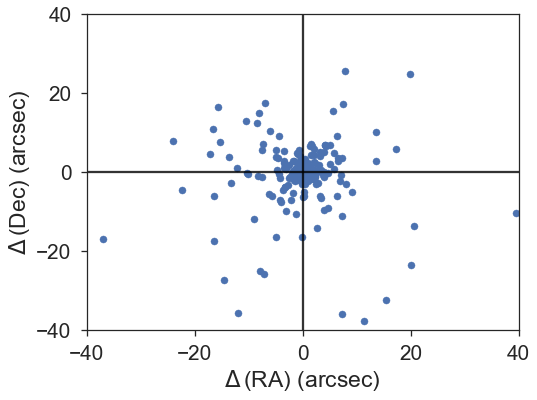

In [15]:
dra, ddec = (cat['RA'] - cat['RA_LSLGA']).data * 3600, (cat['DEC'] - cat['DEC_LSLGA']).data * 3600
print(np.median(dra), np.std(dra), np.median(ddec), np.std(ddec))
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(dra, ddec, s=50)
ax.set_xlim(-40, 40)
ax.set_ylim(-40, 40)
ax.axhline(y=0, ls='-', alpha=0.8, color='k')
ax.axvline(x=0, ls='-', alpha=0.8, color='k')
ax.set_xlabel(r'$\Delta\,$(RA) (arcsec)')
ax.set_ylabel(r'$\Delta\,$(Dec) (arcsec)')
plt.subplots_adjust(bottom=0.15, left=0.15)
fig.savefig('lslga-radec.png')

In [18]:
def get_e1e2(ba, phi):
    ab = 1. / ba
    e = (ab - 1) / (ab + 1)
    ee = -np.log(1 - e)
    angle = np.deg2rad(2. * (-phi))
    ee1 = ee * np.cos(angle)
    ee2 = ee * np.sin(angle)
    return ee1, ee2
        
def type2properties(cat, objtype):
    this = np.where([objtype == tt.strip() for tt in cat['TYPE']])[0]
    if objtype == 'EXP' or objtype == 'REX':
        reff, e1, e2 = cat['SHAPEEXP_R'][this], cat['SHAPEEXP_E1'][this], cat['SHAPEEXP_E2'][this]
    elif objtype == 'DEV':
        reff, e1, e2 = cat['SHAPEDEV_R'][this], cat['SHAPEDEV_E1'][this], cat['SHAPEDEV_E2'][this]
        
    lslga_rad = cat['D25'][this] / 2 * 60 / 2 # [arcmin]
    lslga_e1, lslga_e2 = get_e1e2(cat['BA'][this], cat['PA'][this])
        
    return reff, e1, e2, lslga_rad, lslga_e1, lslga_e2, cat[this]

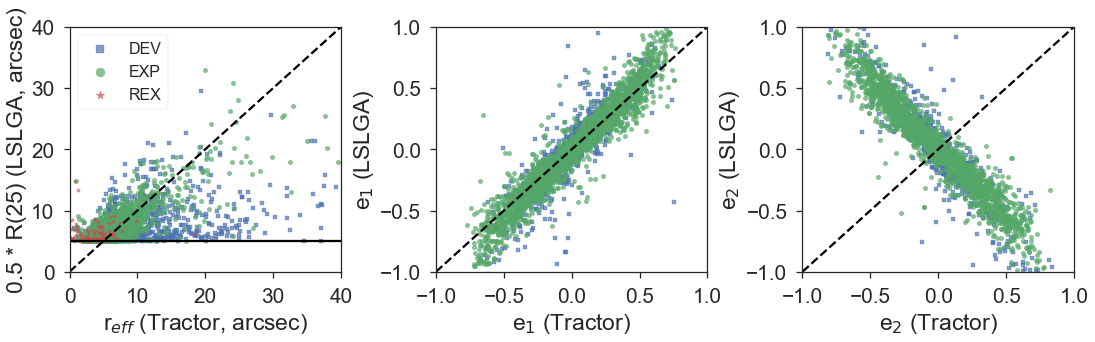

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
#for objtype in ('COMP', 'DEV', 'EXP', 'PSF', 'REX'):
for objtype, marker in zip(('DEV', 'EXP', 'REX'), ('s', 'o', '*')):
    reff, e1, e2, lslga_rad, lslga_e1, lslga_e2, _ = type2properties(cat, objtype)
    ax[0].scatter(reff, lslga_rad, label=objtype, s=20, alpha=0.7, marker=marker)
    if objtype != 'REX':
        ax[1].scatter(e1, lslga_e1, s=20, alpha=0.7, marker=marker)
        ax[2].scatter(e2, lslga_e2, s=20, alpha=0.7, marker=marker)
ax[0].set_xlim(0, 40)
ax[0].set_ylim(0, 40)
ax[0].axhline(y=5, color='k')
ax[0].set_xlabel(r'r$_{eff}$ (Tractor, arcsec)')
ax[0].set_ylabel(r'0.5 * R(25) (LSLGA, arcsec)')
ax[1].set_xlabel(r'e$_1$ (Tractor)')
ax[1].set_ylabel(r'e$_1$ (LSLGA)')
ax[2].set_xlabel(r'e$_2$ (Tractor)')
ax[2].set_ylabel(r'e$_2$ (LSLGA)')
for xx in ax[1:]:
    xx.set_xlim(-1, 1)
    xx.set_ylim(-1, 1)
leg = ax[0].legend(loc='upper left', frameon=True, fontsize=16, markerscale=2)
for l in leg.get_lines():
    l.set_alpha(1)
for xx in ax:
    xx.plot(xx.get_xlim(), xx.get_ylim(), color='k', ls='--')
plt.subplots_adjust(wspace=0.35, bottom=0.2)
plt.savefig('check-lslga.png')

In [40]:
reff, e1, e2, lslga_rad, lslga_e1, lslga_e2, devcat = type2properties(cat, 'DEV')
big = np.where(reff > 25)[0]
for cc in devcat[big][:20]:
    size = np.round(cc['D25'] * 1.5 * 60 / 0.262).astype(int)
    montagefile = 'montage/{}.jpg'.format(cc['GALAXY'].lower())
    jpgfile = []
    #print('http://legacysurvey.org/viewer-dev?ra={}&dec={}&zoom=14&layer=dr8b-decam&lslga'.format(cc['RA'], cc['DEC']))
    for ii, imtype in enumerate(('', '-model', '-resid')):
        jpgfile.append('jpg/{}{}.jpg'.format(cc['GALAXY'].lower(), imtype))
        url = '"http://legacysurvey.org/viewer-dev/jpeg-cutout?ra={}&dec={}&size={}&layer=dr8b-decam{}"'.format(
            cc['RA'], cc['DEC'], size, imtype)
        if not os.path.exists(jpgfile[ii]):
            cmd = 'wget --continue -O {} {}'.format(jpgfile[ii], url)
            print(cmd)
            os.system(cmd)
            time.sleep(1)
    cmd = 'montage -bordercolor white -borderwidth 1 -tile 3x1 -geometry +0+0 '
    cmd = cmd+' '.join(ff for ff in jpgfile)
    cmd = cmd+' {}'.format(montagefile)
    print(cmd)
    os.system(cmd)    

montage -bordercolor white -borderwidth 1 -tile 3x1 -geometry +0+0 jpg/ugc00753.jpg jpg/ugc00753-model.jpg jpg/ugc00753-resid.jpg montage/ugc00753.jpg
montage -bordercolor white -borderwidth 1 -tile 3x1 -geometry +0+0 jpg/pgc1154576.jpg jpg/pgc1154576-model.jpg jpg/pgc1154576-resid.jpg montage/pgc1154576.jpg
wget --continue -O jpg/pgc1121088.jpg "http://legacysurvey.org/viewer-dev/jpeg-cutout?ra=6.637992279295983&dec=-1.3379290078155464&size=306&layer=dr8b-decam"
wget --continue -O jpg/pgc1121088-model.jpg "http://legacysurvey.org/viewer-dev/jpeg-cutout?ra=6.637992279295983&dec=-1.3379290078155464&size=306&layer=dr8b-decam-model"
wget --continue -O jpg/pgc1121088-resid.jpg "http://legacysurvey.org/viewer-dev/jpeg-cutout?ra=6.637992279295983&dec=-1.3379290078155464&size=306&layer=dr8b-decam-resid"
montage -bordercolor white -borderwidth 1 -tile 3x1 -geometry +0+0 jpg/pgc1121088.jpg jpg/pgc1121088-model.jpg jpg/pgc1121088-resid.jpg montage/pgc1121088.jpg
wget --continue -O jpg/pgc090460.